In [1]:
### Imports the whole pinewood_os_d3s sheet, which is quite memory-intensive

import pandas
df_full=pandas.read_csv(('chs_os_d3s.csv'))
df_full

,deviceTime_utc,deviceTime_local,deviceTime_unix,cpm,cpmError,keV_per_ch,0,1,2,3,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,error_flag
0,2018-03-22 21:10:57+00:00,2018-03-22 14:10:57-07:00,1521753057,1189.8,15.425952,2.491468,0,0,0,0,...,1,1,0,1,0,0,1,0,75,NaN
1,2018-03-22 21:15:57+00:00,2018-03-22 14:15:57-07:00,1521753357,1138.8,15.091720,2.491468,0,0,0,0,...,0,0,0,0,0,0,0,0,56,NaN
2,2018-03-22 21:20:58+00:00,2018-03-22 14:20:58-07:00,1521753658,1145.0,15.132746,2.491468,0,0,0,0,...,0,1,0,0,0,0,0,0,79,NaN
3,2018-03-22 21:25:58+00:00,2018-03-22 14:25:58-07:00,1521753958,1161.0,15.238110,2.491468,0,0,0,0,...,0,1,0,0,0,0,0,0,90,NaN
4,2018-03-22 21:30:58+00:00,2018-03-22 14:30:58-07:00,1521754258,1138.0,15.086418,2.491468,0,0,0,0,...,0,0,0,0,0,0,0,0,61,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35109,2019-04-14 22:35:35+00:00,2019-04-14 15:35:35-07:00,1555281335,1205.4,15.526751,2.534722,0,0,0,0,...,0,0,0,0,0,0,0,0,77,NaN
35110,2019-04-14 22:40:35+00:00,2019-04-14 15:40:35-07:00,1555281635,1186.0,15.401299,2.534722,0,0,0,0,...,0,0,0,0,0,0,0,0,64,NaN
35111,2019-04-14 22:45:35+00:00,2019-04-14 15:45:35-07:00,1555281935,1192.8,15.445388,2.534722,0,0,0,0,...,0,0,0,0,0,0,0,0,78,NaN
35112,2019-04-14 22:50:35+00:00,2019-04-14 15:50:35-07:00,1555282235,1196.4,15.468678,2.534722,0,0,0,0,...,0,0,0,0,0,0,1,0,62,NaN


In [2]:
### Importing temperature data from .csv file, change values in "columns" if more/different data is needed
## Only needs to be run once for any number of time ranges being evaluated

columns = ['deviceTime_local','deviceTime_unix','temperature']
import pandas as pd
Tdf = pd.read_csv('chs_os_weather.csv',usecols=columns)
Tdf

,deviceTime_local,deviceTime_unix,temperature
0,2018-03-22 14:10:48-07:00,1521753048,17.95
1,2018-03-22 14:15:48-07:00,1521753348,18.00
2,2018-03-22 14:20:48-07:00,1521753648,18.03
3,2018-03-22 14:25:48-07:00,1521753948,18.12
4,2018-03-22 14:30:48-07:00,1521754248,17.60
...,...,...,...
35874,2018-11-11 13:50:55-08:00,1541973055,21.21
35875,2018-11-11 14:35:55-08:00,1541975755,21.37
35876,2018-11-11 14:45:55-08:00,1541976355,21.15
35877,2018-11-11 14:50:55-08:00,1541976655,21.28


# Data Collection and fitting

## Attempting a method here that runs across all the available data all at once for smaller data sets

In [3]:
### Finding the length of the data set (# of hours that exist between the first and last points)

begin = df_full.loc[0,'deviceTime_unix']
end = df_full.loc[35113,'deviceTime_unix']
diff = round((end-begin)/3600)
diff

9314

In [4]:
### WINTER MONTH (February)


### Fits the radiation counts using a Gaussian + polynomial fit
## Current Settings: 2nd order polynomial (quadratic), peak range of 600-650 keV, std dev max of 20 keV
## Time range of this cell: 8/6-9/5/19 (midnight to midnight, exactly 1 month)
## Expected runtime: ~2 min

# If changing the timescale, the following variables must be redefined appropriately:
# df_month (which slice of df_full is taken), radon_count (should be total number of hours in chosen set), start (convert to unix)
# All other parts of the code should execute properly regardless of the size of the set, though runtime may increase greatly

import pandas as pd
from scipy.signal import find_peaks as fp
import numpy as np
from scipy.optimize import curve_fit

### Creating a dataframe of exactly a month of collected data
col = ['deviceTime_utc','cpmError','1023','error_flag']
df_trim = df_full.reset_index().drop(columns=col) # takes about a month, from 12:01 AM 2/2/18 to 11:59 PM 2/28/18 (local time)
radon_count = np.zeros(diff) # creating an empty dataframe to add hourly radon counts to
total_count = np.zeros(diff) # creating an empty dataframe to add hourly averaged gamma counts to
start = 1521752400 # Setting a baseline time for the loop to start from (in this case it is 12:00:00 Local Time 11/15/18)
end = start

for i in range(0,diff):
    #start = df_month.at[i,'deviceTime_unix']-10 ####### change out the zero for the current for loop index
    #end = start + 3600
    
    ### Sets an hour range for the data, and selecting those rows
    start = end #setting start time based on current index
    end = start + 3600 # end time falls 1 hour after the start time
    hour_set = df_trim['deviceTime_unix'].between(start,end) # Boolean output of rows which fall between start and end times
    hour = df_trim[hour_set].drop(columns=['index','deviceTime_local','deviceTime_unix'])#.sum(axis=0)

    ### Grabs the total counts and puts it into a separate dataframe
    total_count[i] = hour['cpm'].mean()
    
    ### Finding the mean energy per channel from the input, and setting the appropriate energies as column names
    channel_energy = hour['keV_per_ch'].mean(axis=0)
    hour = hour.drop(columns=['cpm','keV_per_ch'])
    col_energy = np.linspace(0,1022*channel_energy,1023)
    hour.columns = col_energy

    ### Taking the mean # of counts for each column (now an energy band)
    hour = hour.mean(axis=0)
    hour1 = pd.DataFrame({'Lower Energy Bounds':hour.index})
    hour2 = pd.DataFrame({'Mean counts':hour}).reset_index(drop=True)
    hour = pd.concat([hour1,hour2],axis=1) # creates a dataframe for the hour, including the energy threshold for each channel and its corresponding counts
    hour = hour.dropna() # drops any empty rows from the dataframe
    if hour.empty==True: # If the dataframe is now empty, there is no spectrum to observe, go to the next hour
        continue

    ### Need to find the peak using the appropriate energy value, not an index
    peak_bounds = hour.iloc[(hour['Lower Energy Bounds']-609.3).abs().argsort()[:2]] # finds the two closest rows to 609.3 keV in energy
    peak_id = peak_bounds.index.sort_values()[0] # outputs the index (channel) that the peak (609.3 keV) is contained in

    ### Sets the window to find the peak based on the peak energy
    window_start = peak_id-80
    window_end = peak_id+80
    window = np.linspace(window_start,window_end,161)
    window_energies = hour.iloc[window_start:window_end+1,0]
    window_counts = hour.iloc[window_start:window_end+1,1]

    ### Defining a combined function of a gaussian and a polynomial, and fitting it to the data
    def gaussian(x,amp,cen,sig):
        return amp*np.exp(-(x-cen)**2/(2*sig**2))
    def gaussian_plus_polynomial(x,amp,cen,sig,a,b,c): 
        return amp*np.exp(-(x-cen)**2/(2*sig**2)) + a*x**2 + b*x + c
    popt,_ = curve_fit(gaussian_plus_polynomial,window_energies,window_counts,bounds =([0,600,0,-1000,-1000,-1000] ,[1000,650,20,1000,0,1000]))
    popt_gaus = popt[0:3]
    popt

    ### Finding the average radon cpm for the hour, adding to overall array
    predicted = gaussian_plus_polynomial(window_energies,*popt)
    radon_count[i] = gaussian(window_energies,*popt_gaus).sum()
    #if i==350:
        #break

In [5]:
### Creates an dataframe of date and time to align counts and temperatures with (purely for readability, is not used in plotting at all)

import time
import numpy as np
import pandas as pd

current_time = 1521748800 # 11:00 PM on 2/1/18
dates = []
hour = []
    
for i in range(0,diff):
    current_time = current_time + 3600
    time1 = time.localtime(current_time) 
    
    year = str(time1[0])
    month = str(time1[1])
    day = str(time1[2])
    
    date_string = [month,day,year]
    #test_string
    dates.append('-'.join(date_string))
    hour.append(time1[3])
    
temp_date = pd.DataFrame({'Date':dates})
temp_hour = pd.DataFrame({'Hour':hour})
DS = pd.concat([temp_date,temp_hour],axis=1)

In [6]:
### Turns Radon outputs into a dataframe, and concatenates with the overall data set
import pandas as pd

Output_Data = pd.DataFrame({'Radon Counts':radon_count})
Output2 = pd.DataFrame({'Total Counts':total_count})
DS = pd.concat([DS,Output_Data,Output2],axis=1)

In [7]:
### Gathering appropriate average temperatures and concatenates with overall dataframe

import pandas as pd
import numpy as np

#T_feb = Tdf[128:7939].reset_index(drop=True)

T_zeros = np.zeros(diff)
T_temp = pd.DataFrame({'Temperature':T_zeros})

T_start = 1521752400
T_end = T_start

for j in range(0,diff):
    T_start = T_end
    T_end = T_start + 3600
    
    T_bool = Tdf['deviceTime_unix'].between(T_start,T_end)
    if T_bool.loc[T_bool==True].empty:
        T_temp.iloc[j,0] = 0
        continue
    T_hourly = Tdf[T_bool].drop(columns=['deviceTime_local','deviceTime_unix'])
    T_temp.iloc[j,0] = T_hourly.mean()

DS = pd.concat([DS,T_temp],axis=1)

In [8]:
### Dropping out any rows that have a zero value for temperature or radon counts

DS_final = DS
Radon_nonzero = (DS_final['Radon Counts'] > 0) # Boolean output of the rows that have positive values for radon count
DS_final = DS_final[Radon_nonzero] # Removes rows with a zero value for radon count
#Radon_negative = (Data_set_final['Radon Counts'] > 0)
#Data_set_final = Data_set_final[Radon_negative]
Temperature_nonzero = (DS_final['Temperature'] != 0) # same idea as Radon_nonzero, but now for temperature
DS_final = DS_final[Temperature_nonzero] # Removes any additional rows that have a 0 value for temperature
#Total_nonzero = (DS_final_Feb['Total Counts'] != 0) These rows shouldn't be necessary since any zeros would be in the same rows as radon counts
#DS_final_Feb = DS_final_Feb[Total_nonzero]

In [9]:
### Checking that the above cell worked properly, not necessary to run every time

(DS_final == 0).sum()

Date             0
Hour            76
Radon Counts     0
Total Counts     0
Temperature      0
dtype: int64

## Stat Analysis

In [10]:
### Finding various stat parameters of the data set

from scipy import stats
import numpy as np
x = DS_final['Temperature'].to_numpy()
y = DS_final['Radon Counts'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(slope,r_value**2,p_value)

-0.008301714082268838 0.00014628227444568728 0.6112032016197286


# Plotting

Text(0, 0.5, 'Weather Station')

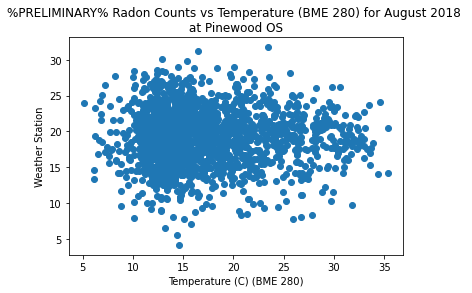

In [46]:
### Plotting radon counts vs temperature for the generated data set

import matplotlib.pyplot as mp
import numpy as np
mp.scatter(DS_final['Temperature'],DS_final['Radon Counts'])
#x = np.linspace(0,25,1000)
#y = x
#mp.plot(x,y,'red')
#mp.legend(['y=x','Temperature Data'])
mp.title('%PRELIMINARY% Radon Counts vs Temperature (BME 280) for August 2018 \n at Pinewood OS ')
mp.xlabel('Temperature (C) (BME 280)')
mp.ylabel('Weather Station')

In [47]:
### Simple linear regression on the data set
import numpy as np

## Reading each column of data, and converting to a numpy array
x=DS_final['Temperature'].to_numpy()
y=DS_final['Radon Counts'].to_numpy()

## Calculating the mean of each array
xmean = np.mean(x)
ymean = np.mean(y)

## Calculating covariance
xycov = (x-xmean)*(y-ymean)
xvar = (x-xmean)**2

## Calculating regression coefficients
beta = xycov.sum()/xvar.sum()
alpha = ymean - (beta*xmean)
print('alpha =',alpha)
print('beta =',beta)

## Predicting y-values based on the model
ypred = alpha + beta*x

## Finding R^2 value for the data set
r = np.corrcoef(x,y)[0,1]
r_squared = r**2
r_squared

alpha = 19.25403728227699
beta = -0.008301714082268836


0.00014628227444568722

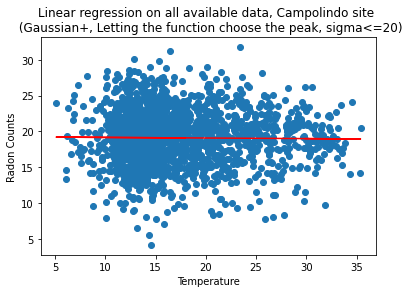

In [48]:
### Plotting regression model alonside original data

import matplotlib.pyplot as mp

mp.scatter(x,y)
mp.plot(x,ypred,color = 'red')
mp.xlabel('Temperature')
mp.ylabel('Radon Counts')
mp.title('Linear regression on all available data, Campolindo site \n (Gaussian+, Letting the function choose the peak, sigma<=20)')
mp.show()